<a href="https://colab.research.google.com/github/Diishasing/CandyCrush/blob/master/GANbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#LOADING THE DATASET

from tensorflow.keras.datasets.mnist import load_data

#load the images to visualize how much data we have
(X_tr, Y_tr), (X_te, Y_te) = load_data()
print('training set: ' , X_tr.shape, Y_tr.shape)
print('testing set: ' , X_te.shape, Y_te.shape)


11501568/11490434 [==============================] - 0s 0us/step
training set:  (60000, 28, 28) (60000,)
testing set:  (10000, 28, 28) (10000,)


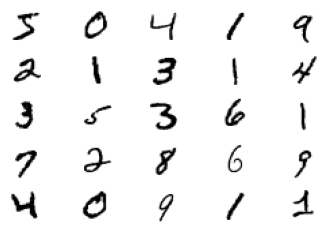

In [ ]:

import matplotlib.pyplot as plt

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis('off')
  plt.imshow(X_tr[i], cmap = 'gray_r')

In [ ]:
#importing all the necessary libraries
import glob
import imageio
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers
import tensorflow as tf
from IPython import display

In [ ]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28,1).astype('float32')
train_images =  (train_images - 127.5)/127.5 #normalize the images to [-1, 1]
train_images

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
#Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7 , 7, 256)
  model.add(layers.Conv2DTranspose(128, (5,5), 
                                   strides = (1,1), padding = 'same', 
                                   use_bias = False))
  assert model.output_shape == (None, 7,7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #UPSAMPLE IT TO 14*14
  model.add(layers.Conv2DTranspose(64, (5,5), 
                                   strides = (2,2), padding = 'same', 
                                   use_bias = False))
  assert model.output_shape == (None, 14,14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #UPSAMPLE IT TO 28*28
  model.add(layers.Conv2DTranspose(1, (5,5), 
                                   strides = (2,2), padding = 'same',  
                                   use_bias = False,
                                   activation = 'tanh'))
  assert model.output_shape == (None, 28,28,1)

  return model

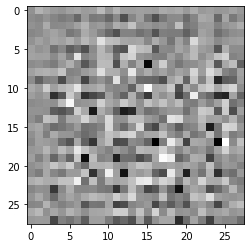

In [ ]:
#sample images generated by generator
generator = make_generator_model()

noise = tf.random.normal([1,100]) #latent space
generated_image = generator(noise,training = False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [ ]:
#discriminator will get fake image from generator and real image from dataset
#and it will discriminate between both the data images
#a discriminator is a cnn image classifier
def make_discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5,5), strides= (2,2), padding = 'same',
                          input_shape= [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides= (2,2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = 'sigmoid'))

  return model

In [ ]:
#discriminator to classify the fake and real image
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.500448]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer  = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer  = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/importante/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
EPOCHS = 1000
noise_dims = 100
num_examples_to_generate  = 16

seed = tf.random.normal([num_examples_to_generate, noise_dims])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dims])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    #produce the display for the gif animation of the generated images
        display.clear_output(wait = True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))


        display.clear_output(wait = True)
        generate_and_save_images(generator,
                             epochs,
                             seed)  

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input,training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap = 'gray')
        plt.axis('off')

    plt.savefig('/content/drive/MyDrive/importante/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()  

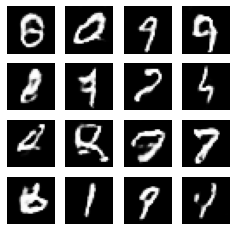

Time for epoch 151 is 14.623204469680786 sec


In [ ]:
train(train_dataset, EPOCHS)